# Computer Vision: Final Project
## Project 6: Snooker

Submitted by:  **Yuval Levi** 


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import cv2

plt.rc('image', cmap='gray') # set the default color-map of plt.image() to 'gray'
plt.rc('figure', figsize=[8,8]) # set a bigger default figure size

## Part 1: Homography from video-table to 2D top view
####   High level:
####    1. Find table lines using probabilitic Hough lines
####    2. Find intersection points of hoguh lines
####    3. Cluster intersection points to 4 corners
####    4. Find homography between 4 points (2D top view image corners and 4 corners found earlier)

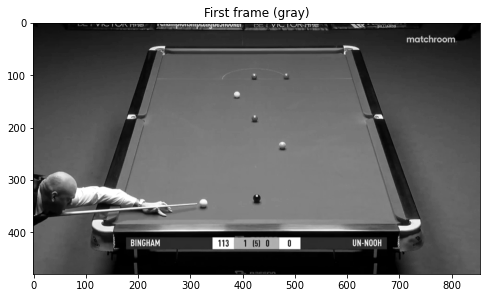

In [2]:
cap = cv2.VideoCapture('P6_Snooker.mp4')

ret, F_ref = cap.read()
F_ref_rgb = cv2.cvtColor(F_ref, cv2.COLOR_BGR2RGB)
F_ref_gray = cv2.cvtColor(F_ref.copy(), cv2.COLOR_BGR2GRAY)
plt.imshow(F_ref_gray)
plt.title("First frame (gray)")
plt.show()

#### 1. Find table lines using probabilitic Hough lines:
    - Adaptive threshold to emphesize table edges
    - Run HoughLinesP to find the table's edges lines

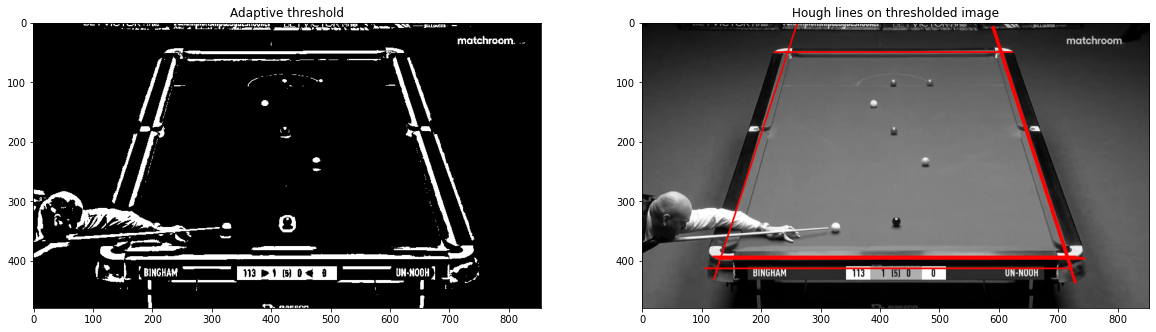

In [3]:
# Adaptive threshold
adaptive_th_img = cv2.adaptiveThreshold(F_ref_gray,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,21,-10)

# Hough lines
table_lines = cv2.HoughLinesP(adaptive_th_img, rho=2,theta=np.pi/20, threshold=600, minLineLength=400,maxLineGap=50) 

# Draw initial hough lines
F_ref_lines = cv2.cvtColor(F_ref_gray,cv2.COLOR_GRAY2RGB)
for x1,y1,x2,y2 in table_lines[:,0,:]:
    cv2.line(F_ref_lines,(x1,y1),(x2,y2),(255,0,0),2)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(adaptive_th_img,cmap='gray')
plt.title("Adaptive threshold")
plt.subplot(1,2,2)
plt.imshow(F_ref_lines)
plt.title("Hough lines on thresholded image")
plt.show()

#### 2. Find intersection points of hoguh lines
    - Find intersection point for each 2 non-parallel lines
    
    - Used help of the following calculation:
        https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines

In [4]:
# Function to find lines intersection point
## Used help of the following calculation:
## https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines

def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    div = det(xdiff, ydiff)
    
    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return ((x),(y))


   ##### find intersection points using above function
    Compare each 2 lines found by hough lines:
    First, check both lines slopes:
        If similar - the lines are parallel so we'll not look for intersection point.
        Else - use intersection function to find the corresponding point.
    Store all intersection points in list "intersection_pts"

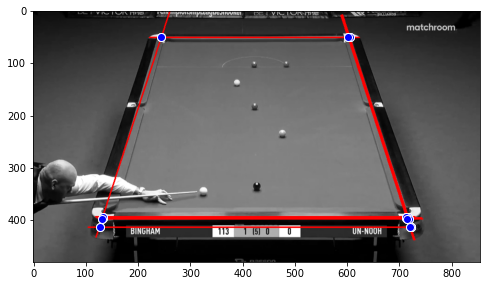

In [5]:
# find intersection points using above function
plt.imshow(F_ref_lines)
intersection_pts = []

for x1,y1,x2,y2 in table_lines[:,0,:]:
    for x3,y3,x4,y4 in table_lines[:,0,:]:
        m1 = abs(((y2-y1)/(x2-x1)))
        m2 = abs(((y4-y3)/(x4-x3)))
        if abs(m1-m2)>0.1:
            intersection_pt = line_intersection(((x1,y1), (x2,y2)), ((x3,y3), (x4,y4)))
            intersection_pts.append(intersection_pt)
            plt.plot(intersection_pt[0],intersection_pt[1],'ob', markeredgecolor='w', markersize=8)

intersection_pts = np.asarray(intersection_pts).astype(np.float32)

#### 3. Cluster intersection points to 4 corners
    - Use KMeans to find 4 corners out of intersection points list
    - Draw table borders based on 4 corners

In [6]:
#### cluster points by kmeans - find 4 best points

# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
crt = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1.0)

# Apply KMeans
compactness,labels,table_corners = cv2.kmeans(intersection_pts,K=4,bestLabels=None,criteria=crt, attempts=50,flags=cv2.KMEANS_RANDOM_CENTERS)

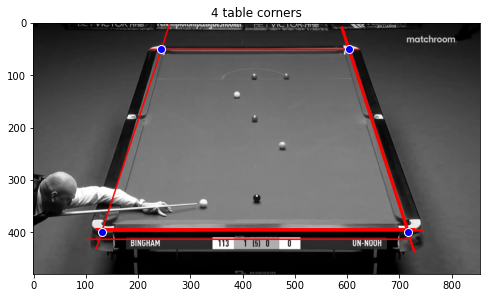

In [7]:
# Show corners
plt.imshow(F_ref_lines)
plt.title("4 table corners")
for pt in table_corners:
    plt.plot(pt[0],pt[1],'ob', markeredgecolor='w', markersize=8)

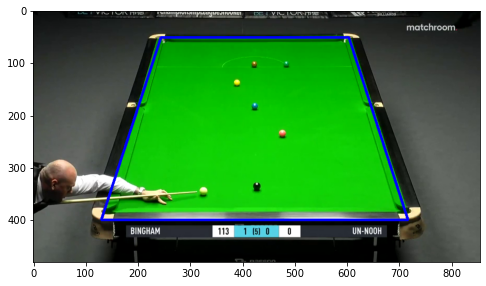

In [8]:
table_corners = np.asarray(table_corners)
table_corners = table_corners.astype(np.int32).reshape(-1,1,2)

# Function to draw table borders
def draw_table_borders(canvas,pt_list):
    pt1,pt2,pt3,pt4 = pt_list[0][0],pt_list[1][0],pt_list[2][0],pt_list[3][0]
    cv2.line(canvas,(int(pt1[0]),int(pt1[1])),(int(pt3[0]),int(pt3[1])),(0,0,255),3)
    cv2.line(canvas,(int(pt2[0]),int(pt2[1])),(int(pt3[0]),int(pt3[1])),(0,0,255),3)
    cv2.line(canvas,(int(pt2[0]),int(pt2[1])),(int(pt4[0]),int(pt4[1])),(0,0,255),3)
    cv2.line(canvas,(int(pt4[0]),int(pt4[1])),(int(pt1[0]),int(pt1[1])),(0,0,255),3)
    return canvas

# Draw table borders on reference frame
F_ref_rgb_borders = F_ref_rgb.copy()
F_ref_rgb_borders = draw_table_borders(F_ref_rgb_borders, table_corners)
plt.imshow(F_ref_rgb_borders)

####    4. Find homography between 4 points (2D top view image corners and 4 corners found earlier)
    - Create a 2D table image (table-height = 2 \* table-width)
    - Find homography matrix from 4 table corner points in ref image to 4 corners of 2D table top image

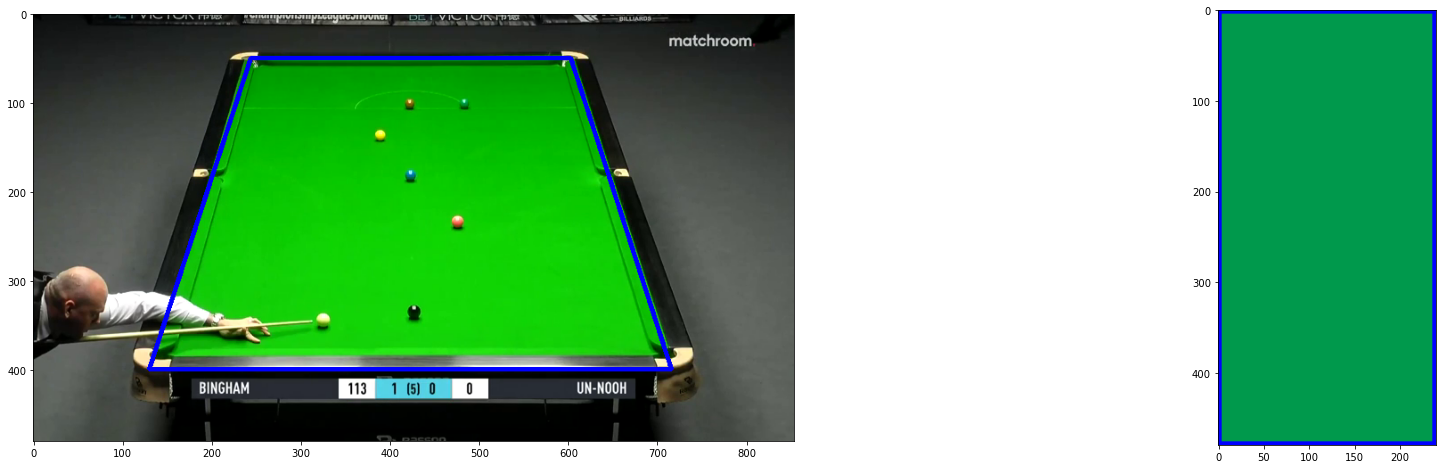

In [9]:
# Create 2D Top View image
def create_2d_top_view():
    h=F_ref_rgb.shape[0]
    w=int(h/2)
    top_view = np.zeros((h,w,3), np.uint8)
    top_view[:,:]=(0,153,76) #Fill table with green color
    cv2.line(top_view,(0,h-1),(w-1,h-1),(0,0,255),5)
    cv2.line(top_view,(0,h-1),(0,0),(0,0,255),5)
    cv2.line(top_view,(w-1,0),(0,0),(0,0,255),5)
    cv2.line(top_view,(w-1,0),(w-1,h-1),(0,0,255),5)
    return top_view

top_view = create_2d_top_view()

# Define 4 corners points of 2D-top-view
h=F_ref_rgb.shape[0]
w=int(h/2)
corners_table_2d = np.int32([ [0,h-1],[w-1,0],[w-1,h-1],[0,0] ]).reshape(-1,1,2)
table_corners = np.int32(table_corners).reshape(-1,1,2)

plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
plt.imshow(F_ref_rgb_borders)
plt.subplot(1,2,2)
plt.imshow(top_view)
plt.show()

In [10]:
# find homography of 4 table corners - real to 2D top view
M, mask = cv2.findHomography(table_corners, corners_table_2d, cv2.RANSAC,5.0)
print("Homography matrix:")
print(M)

Homography matrix:
[[ 7.32054309e-01  2.39123757e-01 -1.90577439e+02]
 [-1.97276710e-16  2.46350304e+00 -1.23175152e+02]
 [-1.17820101e-19  1.99225915e-03  1.00000000e+00]]


## Part 2: Find snooker balls on reference frame
####   High level:
####    1. Convert image to HSV
####    2. Use Hue value to identify each ball's location (by ball color)

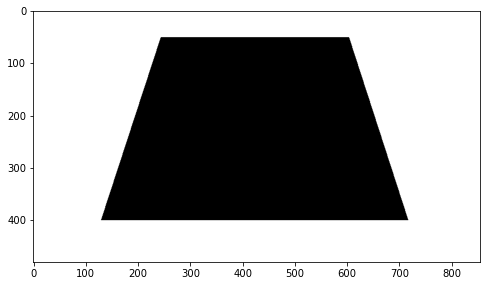

In [11]:
# Create a mask of table area - area to search for balls
table_mask = np.zeros_like(adaptive_th_img)
table_mask = table_mask + 255
table_corners_mask = np.int32([table_corners[3],table_corners[1],table_corners[2],table_corners[0]]).reshape(-1,1,2)
table_mask = cv2.fillPoly(table_mask,[table_corners_mask],(0,0,0))
# table_mask = table_mask.reshape(table_mask.shape[0],table_mask.shape[1])
plt.imshow(table_mask)

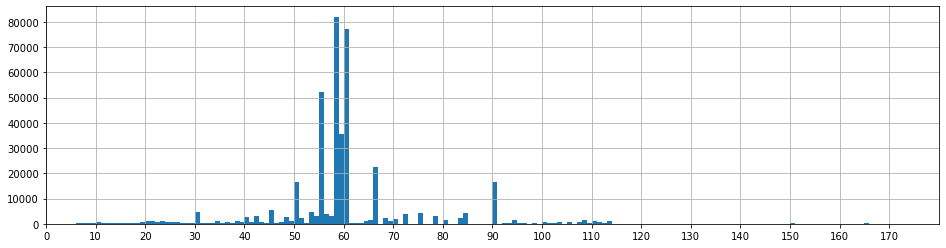

In [12]:
# Blur image (better detection of balls), convert to HSV and plot hue values
img_filtered = cv2.GaussianBlur(F_ref_rgb,(0,0),2)
F_ref_hsv = cv2.cvtColor(img_filtered, cv2.COLOR_RGB2HSV)
plt.figure(figsize=(16,4))
plt.hist(F_ref_hsv[:,:,0].flatten(),255,[1,256]); 
plt.xlim(0,180)
plt.xticks(np.arange(0,180,10))
plt.grid()
plt.show()

In [13]:
# colored balls HSV ranges and RGB colors
yellow_h_range = (30,40)
yellow_ball_color = ((255,255,0))

blue_h_range = (75,100)
blue_ball_color = (((30,144,255)))

green_h_range = (64,85)
green_ball_color = ((50,205,50))

pink_h_range = (0,15)
pink_sat_range = (115,230)
pink_v_range = (0,255)
pink_ball_color = ((219,112,147))

brown_h_range = (0,45)
brown_sat_range = (0,255)
brown_v_range = (0,150)
brown_ball_color = ((150,75,0))

white_ball_color = ((255,255,255))

black_ball_color = ((0,0,0))

**mask_by_color_range(img, color_range, sat_range=[50,255], v_range=[50,255]):**

Used to create a mask image by HSV range to identify a colored ball

**img** - reference image to create the mask from

**color_range** - HSV Hue values range

**sat_range** - HSV Saturation values range (default = [50,255])

**v_range** - HSV Value/lightness values range (default = [50,255])

In [14]:
def mask_by_color_range(img, color_range, sat_range=[50,255], v_range=[50,255]):
    lower = np.array([color_range[0],sat_range[0],v_range[0]])
    upper = np.array([color_range[1],sat_range[1],v_range[1]])
    img_mask = cv2.inRange(img, lower, upper)
    img_mask = np.maximum(img_mask,table_mask)
    return img_mask

**mask_black_ball(img)    &&      mask_white_ball(img)**

Used to create a mask image by HSV range to identify a black/white ball respectively

**img** - reference image to create the mask from

In [15]:
def mask_black_ball(img):
    lower = np.array([0,200,0])
    upper = np.array([180,255,120])
    img_mask = cv2.inRange(img, lower, upper)
    img_mask = np.maximum(img_mask,table_mask)
    return img_mask

In [16]:
def mask_white_ball(img):
    lower = np.array([0,0,230])
    upper = np.array([60,200,255])
    img_mask = cv2.inRange(img, lower, upper)
    img_mask = np.maximum(img_mask,table_mask)
    return img_mask

In [17]:
# Create mask for each ball

yellow_ball_mask_ref = mask_by_color_range(F_ref_hsv, yellow_h_range)

blue_ball_mask_ref = mask_by_color_range(F_ref_hsv, blue_h_range)

green_ball_mask_ref = mask_by_color_range(F_ref_hsv, green_h_range)

pink_ball_mask_ref = mask_by_color_range(F_ref_hsv, pink_h_range, pink_sat_range,pink_v_range)

brown_ball_mask_ref = mask_by_color_range(F_ref_hsv, brown_h_range, brown_sat_range,brown_v_range)

black_ball_mask_ref = mask_black_ball(F_ref_hsv)

white_ball_mask_ref = mask_white_ball(F_ref_hsv)

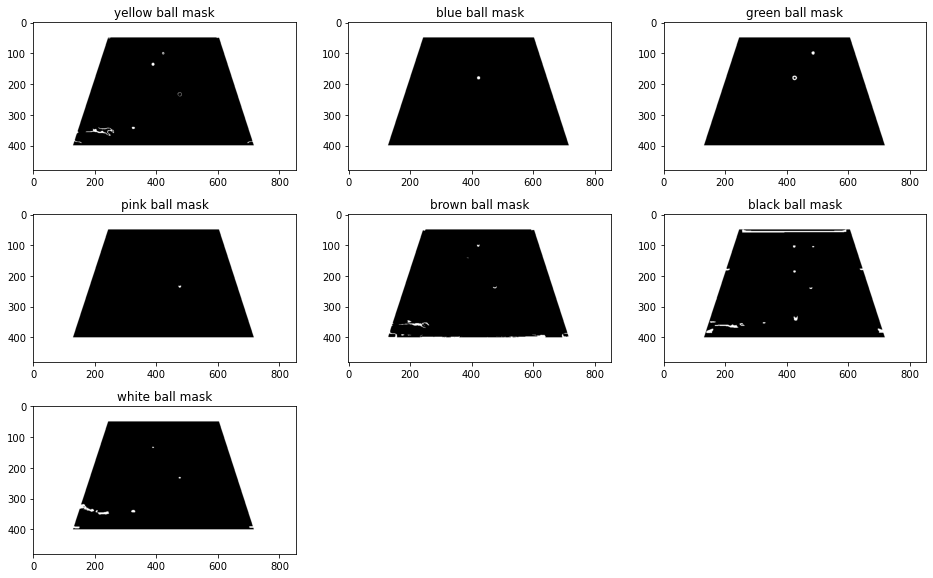

In [18]:
plt.figure(figsize=(16,10))
plt.subplot(3,3,1)
plt.imshow(yellow_ball_mask_ref)
plt.title("yellow ball mask")

plt.subplot(3,3,2)
plt.imshow(blue_ball_mask_ref)
plt.title("blue ball mask")

plt.subplot(3,3,3)
plt.imshow(green_ball_mask_ref)
plt.title("green ball mask")

plt.subplot(3,3,4)
plt.imshow(pink_ball_mask_ref)
plt.title("pink ball mask")

plt.subplot(3,3,5)
plt.imshow(brown_ball_mask_ref)
plt.title("brown ball mask")

plt.subplot(3,3,6)
plt.imshow(black_ball_mask_ref)
plt.title("black ball mask")

plt.subplot(3,3,7)
plt.imshow(white_ball_mask_ref)
plt.title("white ball mask")

plt.show()

**find_ball(mask,ball_list):**

Used to find balls coordinates.
Given a mask image and list of already-found balls, by using Hough Circles finding the ball location (which isn't already exists in balls list)

**mask** - mask image (masked by color)

**ball_list** - list of the balls already found. list order: [yellow, blue, green, pink, brown, black, white]

In [19]:
# [yellow, blue, green, pink, brown, black, white]
ball_list = []

def find_ball(mask,ball_list):
    # Opening - morphology
    kernel = np.ones((3,3),np.uint8)
    mask_erosion = cv2.erode(mask, kernel)
    mask_dilation = cv2.dilate(mask_erosion, kernel)
    
    # Find balls using Hough circles
    balls_circles = cv2.HoughCircles(mask_dilation,method=cv2.HOUGH_GRADIENT,dp=1,minDist=20, param1=160, param2=8,minRadius=3,maxRadius=9)
    
    # In case we found no balls - return False
    if balls_circles is None:
        return False
    
    balls_circles = balls_circles.astype(np.int)
    
    for (x,y,rad) in balls_circles[0]:
        # Make sure circle is not outside table area
        if (np.min(table_corners[:,:,0]) <x< np.max(table_corners[:,:,0])) and (np.min(table_corners[:,:,1]) <y< np.max(table_corners[:,:,1])):
            # Make sure circle coordinates doesn't already exists in ball_list
            if not (pt_in_list((x,y),ball_list)):
                ball_loc = ((x,y))
                ball_list.append((x,y))
                break

    ball_loc = np.int32( ball_loc ).reshape(-1,1,2)
    ball_loc = ball_loc.astype(np.float32)
        
    return ball_loc
    

**pt_in_list(pt0, pt_list):**

Check if a given point coordinates already in list.
Considering small errors, calculation checks if the point is within 5-pixels radius of any of the other points in the list.

**pt0** - the point we wish to check whether already in list.

**pt_list** - list of the points.

In [20]:
def pt_in_list(pt0, pt_list):
    for pt in pt_list:
        if (pt[0]-5< pt0[0]< pt[0]+5) and (pt[1]-5<pt0[1]<pt[1]+5):
            return True
    return False

In [21]:
# Find all balls location
yellow_ball_loc = find_ball(yellow_ball_mask_ref, ball_list)
print("yellow ", yellow_ball_loc[0][0])
blue_ball_loc = find_ball(blue_ball_mask_ref, ball_list)
print("blue ", blue_ball_loc[0][0])
green_ball_loc = find_ball(green_ball_mask_ref, ball_list)
print("green ", green_ball_loc[0][0])
pink_ball_loc = find_ball(pink_ball_mask_ref, ball_list)
print("pink ", pink_ball_loc[0][0])
brown_ball_loc = find_ball(brown_ball_mask_ref, ball_list)
print("brown ", brown_ball_loc[0][0])
black_ball_loc = find_ball(black_ball_mask_ref, ball_list)
black_ref_loc = black_ball_loc
print("black ", black_ball_loc[0][0])
white_ball_loc = find_ball(white_ball_mask_ref, ball_list)
print("white ", white_ball_loc[0][0])

yellow  [389. 136.]
blue  [423. 180.]
green  [483. 100.]
pink  [476. 234.]
brown  [422. 101.]
black  [427. 339.]
white  [324. 342.]


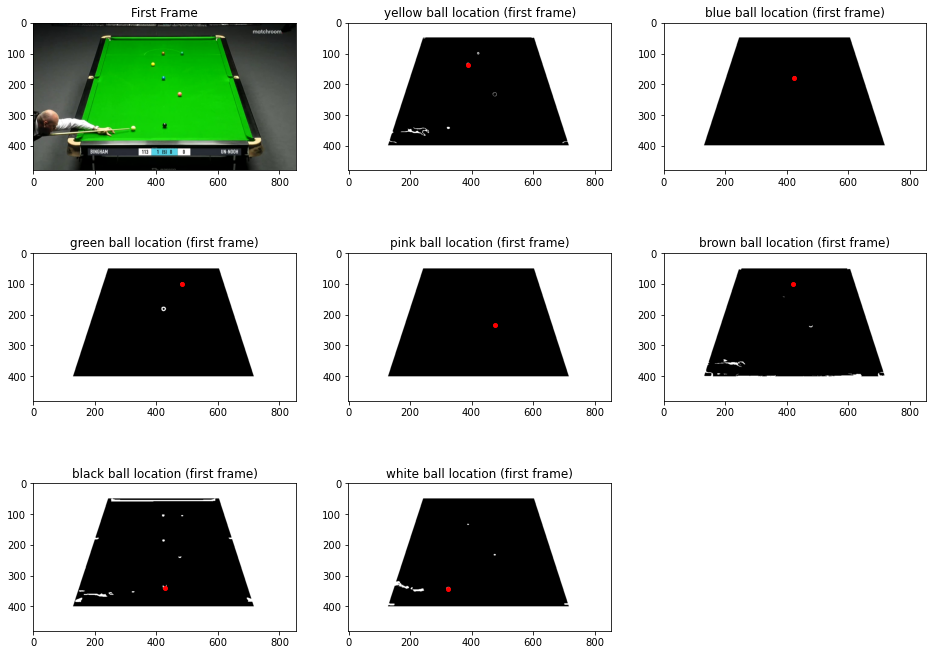

In [22]:
plt.figure(figsize=(16,12))
plt.subplot(3,3,1)
plt.imshow(F_ref_rgb)
plt.title("First Frame")

plt.subplot(3,3,2)
plt.imshow(yellow_ball_mask_ref)
plt.title("yellow ball location (first frame)")
plt.plot(yellow_ball_loc[0][0][0],yellow_ball_loc[0][0][1],'or', markeredgecolor='r', markersize=4)

plt.subplot(3,3,3)
plt.imshow(blue_ball_mask_ref)
plt.title("blue ball location (first frame)")
plt.plot(blue_ball_loc[0][0][0],blue_ball_loc[0][0][1],'or', markeredgecolor='r', markersize=4)

plt.subplot(3,3,4)
plt.imshow(green_ball_mask_ref)
plt.title("green ball location (first frame)")
plt.plot(green_ball_loc[0][0][0],green_ball_loc[0][0][1],'or', markeredgecolor='r', markersize=4)

plt.subplot(3,3,5)
plt.imshow(pink_ball_mask_ref)
plt.title("pink ball location (first frame)")
plt.plot(pink_ball_loc[0][0][0],pink_ball_loc[0][0][1],'or', markeredgecolor='r', markersize=4)

plt.subplot(3,3,6)
plt.imshow(brown_ball_mask_ref)
plt.title("brown ball location (first frame)")
plt.plot(brown_ball_loc[0][0][0],brown_ball_loc[0][0][1],'or', markeredgecolor='r', markersize=4)

plt.subplot(3,3,7)
plt.imshow(black_ball_mask_ref)
plt.title("black ball location (first frame)")
plt.plot(black_ball_loc[0][0][0],black_ball_loc[0][0][1],'or', markeredgecolor='r', markersize=4)

plt.subplot(3,3,8)
plt.imshow(white_ball_mask_ref)
plt.title("white ball location (first frame)")
plt.plot(white_ball_loc[0][0][0],white_ball_loc[0][0][1],'or', markeredgecolor='r', markersize=4)

plt.show()

**mask_balls(img_mask,F_ref):**

Create a colored mask.

**img_mask** - binary mask.

**F_ref** - colored image.

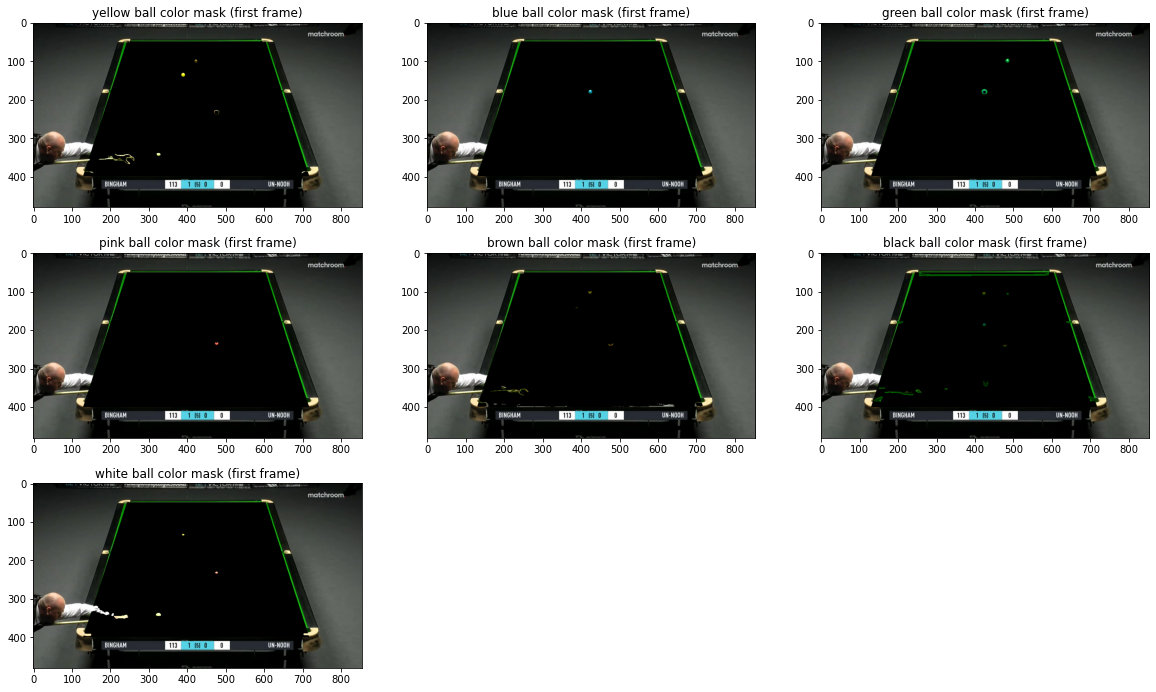

In [23]:
def mask_balls(img_mask,F_ref):
    img_mask_3ch = np.zeros_like(F_ref)
    img_mask_3ch[:,:,0] = img_mask
    img_mask_3ch[:,:,1] = img_mask
    img_mask_3ch[:,:,2] = img_mask
    img = np.minimum(img_mask_3ch,F_ref)
    return img

plt.figure(figsize=(20,12))
plt.subplot(3,3,1)
yellow_ref = mask_balls(yellow_ball_mask_ref, F_ref_rgb)
plt.imshow(yellow_ref)
plt.title("yellow ball color mask (first frame)")

plt.subplot(3,3,2)
blue_ref = mask_balls(blue_ball_mask_ref, F_ref_rgb)
plt.imshow(blue_ref)
plt.title("blue ball color mask (first frame)")

plt.subplot(3,3,3)
green_ref = mask_balls(green_ball_mask_ref, F_ref_rgb)
plt.imshow(green_ref)
plt.title("green ball color mask (first frame)")

plt.subplot(3,3,4)
pink_ref = mask_balls(pink_ball_mask_ref, F_ref_rgb)
plt.imshow(pink_ref)
plt.title("pink ball color mask (first frame)")

plt.subplot(3,3,5)
brown_ref = mask_balls(brown_ball_mask_ref, F_ref_rgb)
plt.imshow(brown_ref)
plt.title("brown ball color mask (first frame)")

plt.subplot(3,3,6)
black_ref = mask_balls(black_ball_mask_ref, F_ref_rgb)
plt.imshow(black_ref)
plt.title("black ball color mask (first frame)")

plt.subplot(3,3,7)
white_ref = mask_balls(white_ball_mask_ref, F_ref_rgb)
plt.imshow(white_ref)
plt.title("white ball color mask (first frame)")

plt.show()

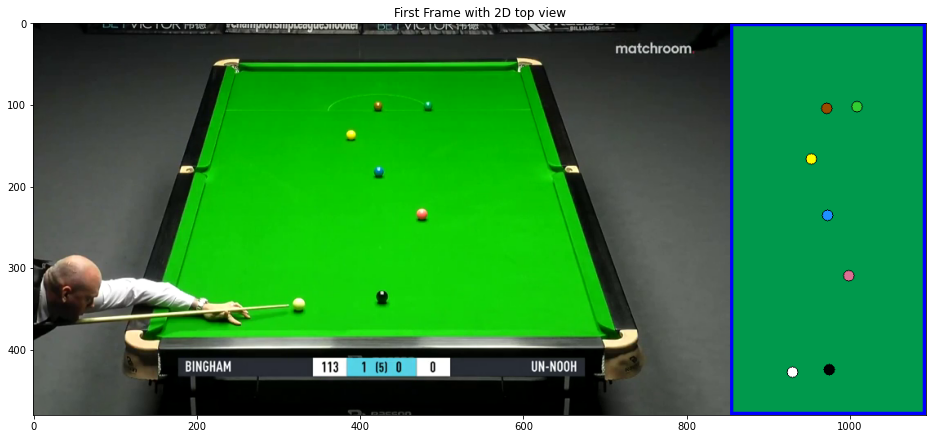

In [24]:
# Create 2D top view and mark balls location (refernce frame)
top_view = create_2d_top_view()
for idx,ball_loc in enumerate(ball_list):
    ball_loc = np.int32([ ball_loc ]).reshape(-1,1,2)
    ball_loc = ball_loc.astype(np.float32)
    
    # Set colors - [yellow, blue, green, pink, brown, black, white]
    if idx==0:
        color = yellow_ball_color
    elif idx==1:
        color = blue_ball_color
    elif idx==2:
        color = green_ball_color
    elif idx==3:
        color = pink_ball_color
    elif idx==4:
        color = brown_ball_color
    elif idx==5:
        color = black_ball_color
    elif idx==6:
        color = white_ball_color

    dst = cv2.perspectiveTransform(ball_loc.astype(np.float),M)
    dst = np.int32(dst)

    for idx,ball in enumerate(dst):
        cv2.circle(top_view,(ball[0][0],ball[0][1]),6,color,-1) #colored circle
        cv2.circle(top_view,(ball[0][0],ball[0][1]),7,(0,0,0),1) #black outline

        
plt.figure(figsize=(16,20))
first_frame_to2d = np.concatenate((F_ref_rgb, top_view), axis=1)
plt.imshow(first_frame_to2d)
plt.title("First Frame with 2D top view")
plt.show()

## Part 3: Track balls frame-to-frame
####   High level:
####    1. For each new frame - create a mask for each ball color
####    2. Track each ball new location using Optical Flow (from last frame colored-mask to new frame colored-mask)
####    3. Check if new ball's location is within search radius of one of the holes (and remove ball from top view)
####    4. paint ball on top view in new location
----

**ball_in_hole(ball_loc):**

Check if ball has entered a hole (within search radius of 6 holes)

**ball_loc** - current location of a ball.

In [25]:
# Create list of holes - 4 table corners + mid-point of the 2 longer sides of the table.
holes = []
for idx,corner in enumerate(corners_table_2d):
    holes.append(((corners_table_2d[idx][0][0],corners_table_2d[idx][0][1]), 21))
holes.append((((int(corners_table_2d[0][0][0])),int(corners_table_2d[0][0][1]/2)),11))
holes.append((((int(corners_table_2d[2][0][0])),int(corners_table_2d[2][0][1]/2)),11))

# Check if ball location is near hole
def ball_in_hole(ball_loc):
    for hole, rad in holes:
        if hole[0]-rad<ball_loc[0][0][0]<hole[0]+rad:
            if hole[1]-rad<ball_loc[0][0][1]<hole[1]+rad:
                return True
    return False

In [26]:
# Function to mask white ball - as before, but fine-tuned for better tracking
def mask_white_ball_for_tracking(img):
    lower = np.array([0,55,245])
    upper = np.array([180,255,255])
    img_mask = cv2.inRange(img, lower, upper)
    img_mask = np.maximum(img_mask,table_mask)
    return img_mask

In [27]:
# Update some values - better for tracking
brown_h_range = (0,45)
brown_sat_range = (200,255)
brown_v_range = (0,150)

pink_h_range = (0,10)
pink_sat_range = (115,220)
pink_v_range = (60,180)

black_ball = False

**paint_ball_on_view(top_view,ball_color,coordinates):**

Paint a ball on the top-view canvas.

**top_view** - canvas to draw on.

**ball_color** - color for the ball.

**coordinates** - location to draw on the canvas.


In [28]:
def paint_ball_on_view(top_view,ball_color,coordinates):
    for idx,ball in enumerate(coordinates):
        cv2.circle(top_view,(ball[0][0],ball[0][1]),6,ball_color,-1)
        cv2.circle(top_view,(ball[0][0],ball[0][1]),7,(0,0,0),1)
    return top_view

**track_ball(pre_frame, curr_frame, prev_loc, top_view, color_range, ball_color, s_range=[50,255], v_range=[50,255]):**

Track a ball using optical flow (previous frame mask to new frame mask)

**pre_frame** - previous frame colored mask.

**curr_frame** - current frame (RGB).

**prev_loc** - Location of the ball in previous frame.

**top_view** - canvas to draw the ball after finding the new location.

**color_range** - Hue value to transfer to "mask_by_color_range" function.

**ball_color** -  RGB color of ball draw it on canvas.

**s_range** -  Saturation value to transfer to "mask_by_color_range" function.

**v_range** -  Value (HSV) value to transfer to "mask_by_color_range" function.

In [29]:
def track_ball(pre_frame, curr_frame, prev_loc, top_view, color_range, ball_color, s_range=[50,255], v_range=[50,255], c=0):
    
    # Optical flow params
    lk_params = dict( winSize  = (20,20),
              maxLevel = 5,
              criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.00003))  
    
    curr_frame_hsv = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2HSV)
    if color_range==(0,0): #black
        if c>235:
            dst = cv2.perspectiveTransform(black_ref_loc.astype(np.float),M)
            dst = np.int32(dst)
            top_view = paint_ball_on_view(top_view,black_ball_color,dst)
            return top_view, curr_frame, black_ref_loc
        else:
            mask_curr = mask_black_ball(curr_frame_hsv)
    elif color_range==(255,255):#white
        mask_curr = mask_white_ball_for_tracking(curr_frame_hsv)
        if prev_loc[0][0][1]<150:  # if ball is "far" dilate the mask for better detection of ball
            kernel = np.ones((5,5),np.uint8)
            mask_curr = cv2.dilate(mask_curr, kernel)
    else: #color
        mask_curr = mask_by_color_range(curr_frame_hsv, color_range, s_range, v_range)
        
    if prev_loc is None:
        return top_view,curr_frame,None  
        
    curr_frame = mask_balls(mask_curr, curr_frame)
    # Optical Flow
    ball_new_loc, status, err = cv2.calcOpticalFlowPyrLK(pre_frame, curr_frame, prev_loc, None, **lk_params)
    
    dst = cv2.perspectiveTransform(ball_new_loc.astype(np.float),M)
    dst = np.int32(dst)
    prev_loc_transform = cv2.perspectiveTransform(prev_loc.astype(np.float),M)
    prev_loc_transform = np.int32(prev_loc_transform)

    # If ball location is near a hole - remove it and set location None
    if ball_in_hole(dst):
        ball_new_loc = None
        return top_view, curr_frame, ball_new_loc
    
    # If we got here and ball's status is 0, probably ball is blocked by view. Set the current location to last known location.
    if status[0] == 0:
        ball_new_loc = prev_loc

    # Draw the ball on the top view at current location
    top_view = paint_ball_on_view(top_view,ball_color,dst)
    
    return top_view, curr_frame, ball_new_loc

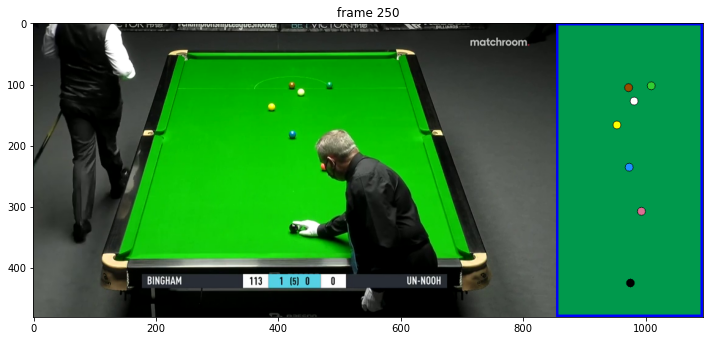

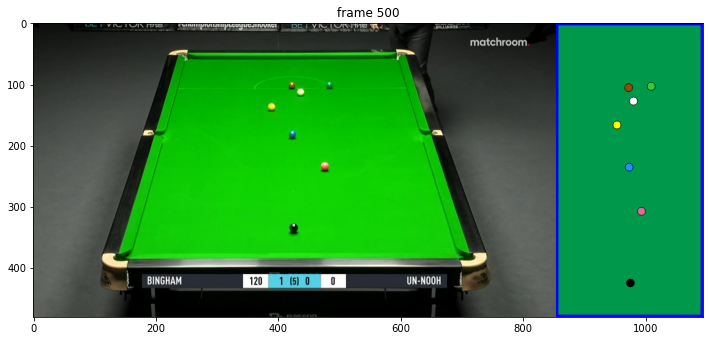

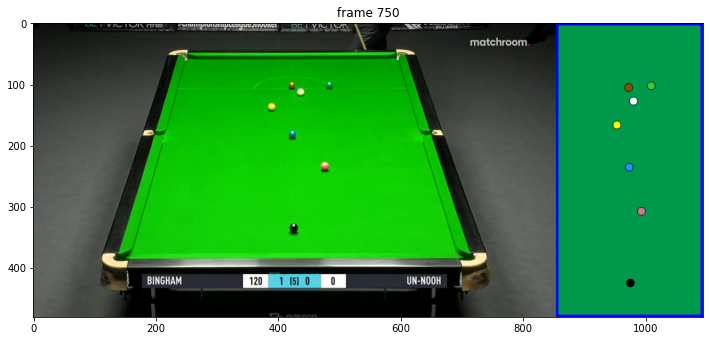

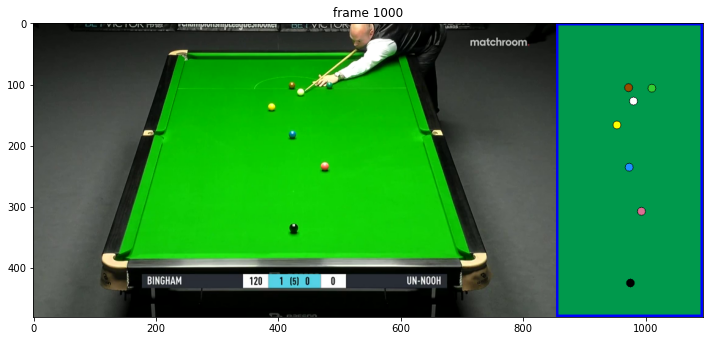

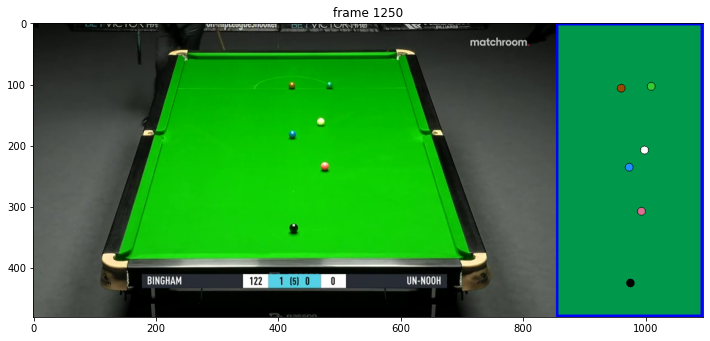

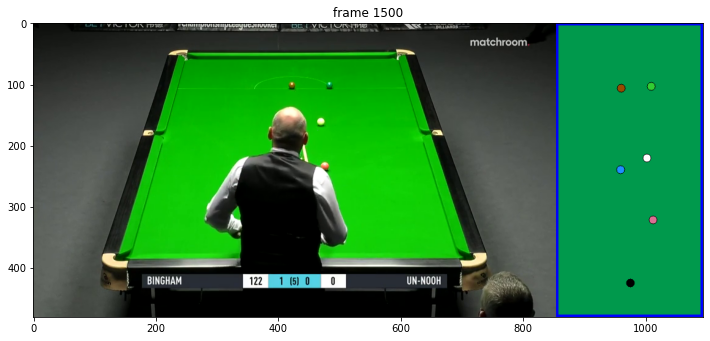

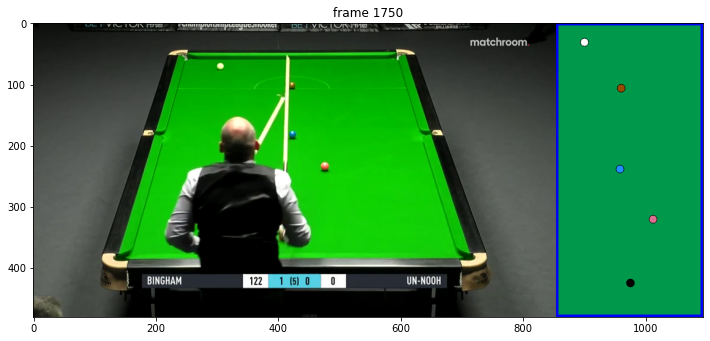

-1

In [30]:
# Video out params
cap = cv2.VideoCapture('P6_Snooker.mp4')
FPS = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
H = int(first_frame_to2d.shape[0])
W = int(first_frame_to2d.shape[1])
out = cv2.VideoWriter('P6_Snooker_2D_Top.mp4',fourcc, FPS, (W,H))


# First frame - set previous to reference (0)
F_prev_yellow = yellow_ref
F_prev_blue = blue_ref
F_prev_green = green_ref
F_prev_pink = pink_ref
F_prev_brown = brown_ref
F_prev_black = black_ref
F_prev_white = white_ref


counter = 0
while(1):
    ret,F_current = cap.read()
    
    if ret==True:
        top_view = create_2d_top_view()
        F_current_rgb = cv2.cvtColor(F_current, cv2.COLOR_BGR2RGB)        
        F_current_rgb = cv2.GaussianBlur(F_current_rgb,(0,0),2)
        F_current_rgb_wh = cv2.GaussianBlur(F_current_rgb,(5,5),0)
        
        # Track yellow ball
        top_view_curr, yellow_curr_frame, yellow_new_loc = track_ball(F_prev_yellow, F_current_rgb, yellow_ball_loc, top_view, yellow_h_range, yellow_ball_color)
        
        # Track blue ball
        top_view_curr, blue_curr_frame, blue_new_loc = track_ball(F_prev_blue, F_current_rgb, blue_ball_loc, top_view, blue_h_range, blue_ball_color)

        # Track green ball
        top_view_curr, green_curr_frame, green_new_loc = track_ball(F_prev_green, F_current_rgb, green_ball_loc, top_view, green_h_range, green_ball_color)

        # Track pink ball
        top_view_curr, pink_curr_frame, pink_new_loc = track_ball(F_prev_pink, F_current_rgb, pink_ball_loc, top_view, pink_h_range, pink_ball_color, pink_sat_range, pink_v_range)

        # Track brown ball
        top_view_curr, brown_curr_frame, brown_new_loc = track_ball(F_prev_brown, F_current_rgb, brown_ball_loc, top_view, brown_h_range, brown_ball_color, brown_sat_range, brown_v_range)
    
        # Track black ball
        top_view_curr, black_curr_frame, black_new_loc = track_ball(F_prev_black, F_current_rgb, black_ball_loc, top_view, (0,0), black_ball_color,(0,0),(0,0), counter)
            
        # Track white ball
        top_view_curr, white_curr_frame, white_new_loc = track_ball(F_prev_white, F_current_rgb_wh, white_ball_loc, top_view, (255,255), white_ball_color)
            

        # Show frame and its top view and write to video file
        top_view_bgr = cv2.cvtColor(top_view, cv2.COLOR_RGB2BGR)        
        merged_img = np.concatenate((F_current, top_view_bgr), axis=1);
        cv2.imshow('Snooker Game with Top View', merged_img)
        out.write(merged_img)
        
        # update previous frame & previous ball location for optical flow
        F_prev_yellow = yellow_curr_frame
        yellow_ball_loc = yellow_new_loc
        F_prev_blue = blue_curr_frame
        blue_ball_loc = blue_new_loc
        F_prev_green = green_curr_frame
        green_ball_loc = green_new_loc
        F_prev_pink = pink_curr_frame
        pink_ball_loc = pink_new_loc
        F_prev_brown = brown_curr_frame
        brown_ball_loc = brown_new_loc
        F_prev_black = black_curr_frame
        black_ball_loc = black_new_loc
        F_prev_white = white_curr_frame
        white_ball_loc = white_new_loc
        counter+=1
        
        # Output frame and its top view to notebook every 250 frames (for illustration)
        if (counter%250)==0:
            plt.figure(figsize=(12,12))
            plt.imshow(cv2.cvtColor(merged_img, cv2.COLOR_BGR2RGB))
            plt.title(f'frame {counter}')
            plt.show()
            
        k = cv2.waitKey(1) & 0xff
        if k == 27:
            break
            
    else: # no frames to read
        break

cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

## Thank you! :)